In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


You are offering a commodity or asset for some price $x$ to customers. The customer decision to buy or not follows $Bern(p(x))$, where the probability of a buy $p(x)$ is a decreasing function of the price. Your expected revenue is $x p(x)$. You increase the price, does this affect the probability of a buy? If it does not, you have increased the revenue.

This is equivalent to comparing two coins if the probability of success has increased.

# 1. Test if coin bias has changed (small sample)

The below comparions are considering a positive change in $p$. However, due to symmetry, this can be easily applied to a decrease in $p$.

## 1.1. Naive method $P(\hat{p}_1 > \hat{p}_0)$

Let $X_i \sim Bin(n_i, p_i)$

with probability mass function denoted by $f(k; n_i, p_i)$.

Define the change in success rate $D =: p_1 - p_0$, which has MLE estimate

$\hat{D} = \hat{p}_1 - \hat{p}_0 = \frac{X_1}{n_1} - \frac{X_0}{n_0}$.

Then $P(\hat{D} > 0) = \sum \limits_{G} f(k_0, n_0, p_0)f(k_1, n_1, p_1)$, 

where $G = \{k_0, k_1 : \frac{k_1}{n_1} - \frac{k_0}{n_0} > 0 \}$.


Hence, the probability is a function of $p_0,p_1$, which we do not know.

Naively, we can replace $p_0,p_1$ with their MLE point estimates, yielding

$\widehat{P}(\hat{D} > 0) = \sum \limits_{G} f(k_0, n_0, \hat{p}_0)f(k_1, n_1, \hat{p}_1)$.

Note that this is a random quantity with respect to $\hat{p}_0$ and $\hat{p}_1$. Hence, the marginal distribution is given as a binomial with a binomial prior.

Taking expectations yields
\begin{align}
E[\widehat{P}(\hat{D} > 0)] &= \sum\limits_{p_0,p_1} P(\hat{D} > 0|p_0, p_1)P(p_0,p_1) \\
& = \sum\limits_{s_0,s_1} \sum \limits_{G} f(k_0, n_0,\frac{s_0}{n_0})f(s_0, n_0,p_0) \cdot f(k_1, n_1, \frac{s_1}{n_1})f(s_1, n_1,p_1)
\end{align}
which again is a function of the unknown nuance parameters $p_0,p_1$.

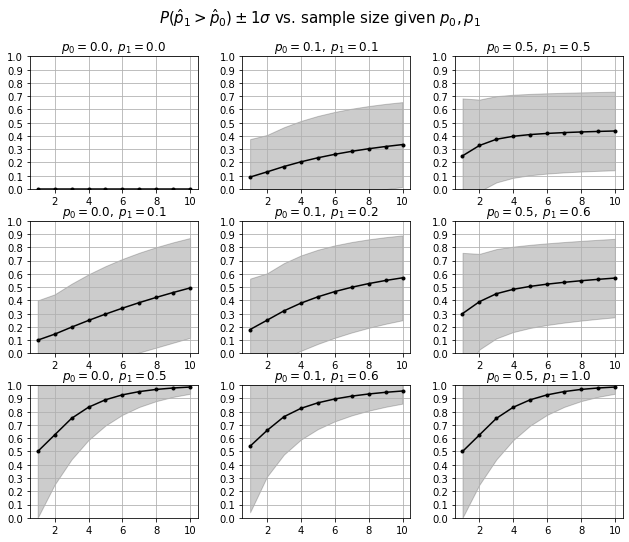

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.stats as stats
from scipy.special import comb
np.seterr('raise')


def naive_exact(n:int, p0, theta): # Pr(Dhat > 0) = Sum Pr(D|p0,p1)*Pr(p0,p1)
    p1 = p0 + theta
    mom1 = 0 # 1st moment = mean
    mom2 = 0 # 2nd moment = var + mean^2
    for a0 in range(n+1):
        for a1 in range(n+1):
            q0 = a0 / n
            q1 = a1 / n
            prior_pmf = stats.binom.pmf(a0, n, p0)*stats.binom.pmf(a1, n, p1)
            pgeq = 0
            for k0 in range(n + 1):
                for k1 in range(n + 1):
                    if k1/n - k0/n > 0:
                        #epr += prior_pmf * stats.binom.pmf(k0, n, q0) * stats.binom.pmf(k1, n, q1)
                        pgeq += stats.binom.pmf(k0, n, q0) * stats.binom.pmf(k1, n, q1)
            mom1 += pgeq * prior_pmf
            mom2 += pgeq**2 * prior_pmf
    mean = mom1
    std = (mom2 - mom1**2)**0.5
    return mean, std

pp0 = [0.0, 0.1, 0.5]
thetas = [0.0, 0.1, 0.5]
n_max = 10
nn = np.arange(n_max) + 1

fig, axs = plt.subplots(3, 3, figsize=(9,7))
fig.suptitle('$P(\hat{p}_1 > \hat{p}_0) \pm 1\sigma$ vs. sample size given $p_0, p_1$', fontsize=15, y=1.07)
fig.tight_layout()

for row in range(len(thetas)):
    for col in range(len(pp0)):
        mean, std = zip(*[naive_exact(n, pp0[col], thetas[row]) for n in nn])
        mean = np.array(mean)
        std = np.array(std)
        #pgeq = np.array([naive_exact(n, pp0[col], thetas[row]) for n in nn])
        axs[row,col].plot(nn, mean, marker='.', color='k')
        axs[row,col].fill_between(nn, mean-std, mean+std, color='k', alpha=0.2)
        axs[row,col].set_ylim([0, 1.0])
        axs[row,col].set_yticks(np.arange(11)/10)
        axs[row,col].set_title('$p_0={}, \; p_1={}$'.format(pp0[col], pp0[col]+thetas[row]))
        axs[row,col].grid()
    
plt.show()

## 1.2. Bayesian posterior with uniform priors $P(\hat{p}_1 > \hat{p}_0)$

In the previous method, we used the MLE for finding the possible values of $p$. This method finds the binomial distirbusion that is most likely to have generated the data, i.e. the mode of the likelihood function. However, instead of using the most likely distribution, we can create a weighning of an infinite distributions with weights equal to the likelihood function. This is equivalent to finding the posterior distribution with a uniform prior.

For a single observation from a binomial we have that $\mathcal{L}(p|k) = f(k,n,p)$

Previously, we found that $\hat{p}= k/n$ is the estimator that maximizes $\mathcal{L}(p|k)$. Now instead we turn $\mathcal{L}(p|k)$ into a density function using a uniform prior for the binomial parameters.

$\hat{p}|x \sim P(p|x) = \frac{\mathcal{L}(p|x) P(p)}{P(x)} \sim Beta(x+1, n-x+1)$


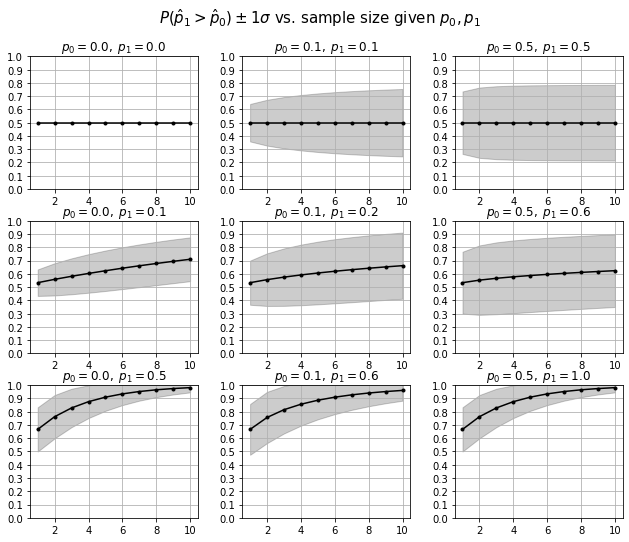

In [3]:
import scipy.special as special
from scipy.integrate import quad

def naive_bayes(n:int, p0, theta): # Pr(Dhat > 0) = Sum Pr(D|p0,p1)*Pr(p0,p1)
    p1 = p0 + theta
    mom1 = 0 # 1st moment = mean
    mom2 = 0 # 2nd moment = var + mean^2
    for a0 in range(n+1):
        for a1 in range(n+1):
            prior_pmf = stats.binom.pmf(a0, n, p0)*stats.binom.pmf(a1, n, p1)
            
            p0hd = stats.beta(a=a0+1, b=n-a0+1) # Posterior0
            p1hd = stats.beta(a=a1+1, b=n-a1+1) # Posterior1
            pgeq = quad(lambda p : p0hd.cdf(p)*p1hd.pdf(p), 0, 1)[0]
            
            mom1 += pgeq * prior_pmf
            mom2 += pgeq**2 * prior_pmf
    mean = mom1
    std = (mom2 - mom1**2)**0.5
    return mean, std


pp0 = [0.0, 0.1, 0.5]
thetas = [0.0, 0.1, 0.5]
n_max = 10
nn = np.arange(n_max) + 1

fig, axs = plt.subplots(3, 3, figsize=(9,7))
fig.suptitle('$P(\hat{p}_1 > \hat{p}_0) \pm 1\sigma$ vs. sample size given $p_0, p_1$', fontsize=15, y=1.07)
fig.tight_layout()

for row in range(len(thetas)):
    for col in range(len(pp0)):
        mean, std = zip(*[naive_bayes(n, pp0[col], thetas[row]) for n in nn])
        mean = np.array(mean)
        std = np.array(std)
        #pgeq = np.array([naive_exact(n, pp0[col], thetas[row]) for n in nn])
        axs[row,col].plot(nn, mean, marker='.', color='k')
        axs[row,col].fill_between(nn, mean-std, mean+std, color='k', alpha=0.2)
        axs[row,col].set_ylim([0, 1.0])
        axs[row,col].set_yticks(np.arange(11)/10)
        axs[row,col].set_title('$p_0={}, \; p_1={}$'.format(pp0[col], pp0[col]+thetas[row]))
        axs[row,col].grid()
    
plt.show()

## 1.2. Bayesian $P(\hat{p}_1 > \hat{p}_0)$

$prior_1 = posterior_0$ and  $prior_0=Beta(1,1)$

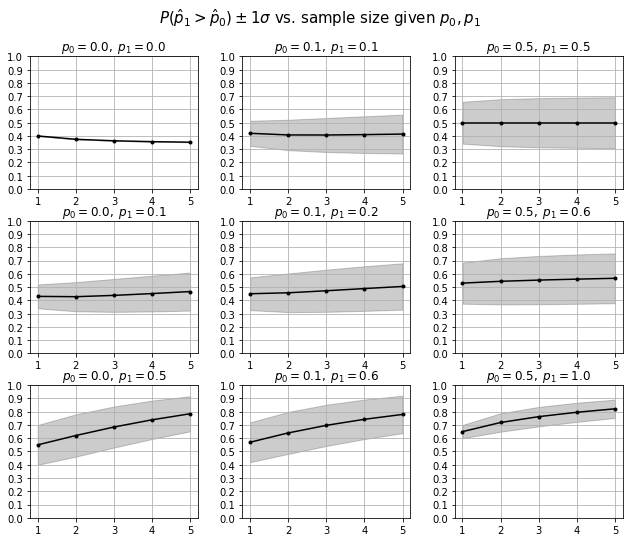

In [11]:
import scipy.special as special
from scipy.integrate import quad

def naive_bayes(n:int, p0, theta): # Pr(Dhat > 0) = Sum Pr(D|p0,p1)*Pr(p0,p1)
    p1 = p0 + theta
    mom1 = 0 # 1st moment = mean
    mom2 = 0 # 2nd moment = var + mean^2
    for a0 in range(n+1):
        for a1 in range(n+1):
            prior_pmf = stats.binom.pmf(a0, n, p0)*stats.binom.pmf(a1, n, p1)
            
            p0hd = stats.beta(a=a0+1, b=n-a0+1) # Posterior0
            p1hd = stats.beta(a=(a0+1) + a1, b=(n-a0+1) + n-a1) # Posterior1
            pgeq = quad(lambda p : p0hd.cdf(p)*p1hd.pdf(p), 0, 1)[0]
            
            mom1 += pgeq * prior_pmf
            mom2 += pgeq**2 * prior_pmf
    mean = mom1
    std = (mom2 - mom1**2)**0.5
    return mean, std


pp0 = [0.0, 0.1, 0.5]
thetas = [0.0, 0.1, 0.5]
n_max = 5
nn = np.arange(n_max) + 1

fig, axs = plt.subplots(3, 3, figsize=(9,7))
fig.suptitle('$P(\hat{p}_1 > \hat{p}_0) \pm 1\sigma$ vs. sample size given $p_0, p_1$', fontsize=15, y=1.07)
fig.tight_layout()

for row in range(len(thetas)):
    for col in range(len(pp0)):
        mean, std = zip(*[naive_bayes(n, pp0[col], thetas[row]) for n in nn])
        mean = np.array(mean)
        std = np.array(std)
        #pgeq = np.array([naive_exact(n, pp0[col], thetas[row]) for n in nn])
        axs[row,col].plot(nn, mean, marker='.', color='k')
        axs[row,col].fill_between(nn, mean-std, mean+std, color='k', alpha=0.2)
        axs[row,col].set_ylim([0, 1.0])
        axs[row,col].set_yticks(np.arange(11)/10)
        axs[row,col].set_title('$p_0={}, \; p_1={}$'.format(pp0[col], pp0[col]+thetas[row]))
        axs[row,col].grid()
    
plt.show()

## 1.2. Hypothesis Testing method

![title](hypotheses_probtree.png)

Given some data, we want to test if the data is coming from the model specified by H0, or if it is more likely to have come from an alternative model specified by H1.

The testing procedure we choose determines our probability of rejecting or accepting a model. We want to minimize the probability of making false conclusions, $\alpha:=P(\text{reject} \; \mathcal{H}_0|\mathcal{H}_0 \; \text{true})$ and $\beta:=P(\text{accept} \; \mathcal{H}_1|\mathcal{H}_1 \; \text{true})$. It is common to define $\text{Power}:=1-\beta = P(\text{reject} \; \mathcal{H}_0|\mathcal{H}_1 \; \text{true})$.

The parameter $\alpha$ is the significance level, and is often chosen to be small. Given a fixed $\alpha$, a good testing procedure yields high power. The power is an increasing function of $\alpha$ and sample size.

In classical frequentist binary hypothesis testing, having observed the data, and drawn a conclusion whether to reject or not, we can never conclude anything about the <u>probability</u> of $\mathcal{H}_0$ being true. We are only given certain guarantees in false conclusions in either case. To see why, the probability of $\mathcal{H}_0$ being true given that the testing rejected $\mathcal{H}_0$ in favor of $\mathcal{H}_1$ is given by Bayes theorem

$P(\mathcal{H}_0|\text{reject} \; \mathcal{H}_0) = \frac{ P(\text{reject} \; \mathcal{H}_0|\mathcal{H}_0)P(\mathcal{H}_0) }{P(\text{reject})} = \frac{\alpha P(\mathcal{H}_0) }{\alpha P(\mathcal{H}_0) + \text{PWR} \cdot P(\mathcal{H}_1)}$

Hence, we need to know the _prior probabilities_ $P(\mathcal{H}_0)$ and $P(\mathcal{H}_1)$, which are unknown to us. We need to decide on these a priori in order to draw any conclusions. If we have no belief that one hypothesis is more likely than the other, then we can set $P(\mathcal{H}_0)=P(\mathcal{H}_1)=0.5$, which will result in

$P(\mathcal{H}_0|\text{reject} \; \mathcal{H}_0) = \left(1+\frac{\text{PWR}}{\alpha}\right)^{-1}$

$P(\mathcal{H}_0|\text{accept} \; \mathcal{H}_0) = \left(1+\frac{1-\text{PWR}}{1-\alpha}\right)^{-1}$

### 1.2.1. Frequentism

$X_i \sim Bin(n_i,p_i)$

Consider the change in success rate $D = p_1 - p_2$ and we want to test

\begin{align}
\mathcal{H}_0:& \; D = 0 \\
\mathcal{H}_1:& \; D > 0
\end{align}

This is also known as a single sided test for a difference in proportions.

We reject the null hypothesis in favor of the alternative hypothesis when the observation $\hat{D}$ is larger than some critical value $c$. The critical value is chosen such that the number of false rejections under $\mathcal{H}_0$ is upper bounded by significance level $\alpha$, i.e. $P(\hat{D} \geq c |\mathcal{H}_0) \leq \alpha$. Using this same critical value under a specific $\mathcal{H}_1$, the number of true rejections, i.e. test power, is given by $Power = P(\hat{D} \geq c |\mathcal{H}_1)$.

Note that in the frequentist approach, we have conditioned on a hypothesis being true. That is, have no probability of either hypothesis occuring.


#### 1.2.1.1 Distribution of $\hat{D}$

The problem we face is that the distribution of $\hat{D}$ depends on the true parameters $p_0, p_1$.
We cannot easily create a test statistic that is invariant to these parameters.

Note that since
\begin{align}
E[\hat{D}|\mathcal{H}_0] &= 0 \\
V[\hat{D}|\mathcal{H}_0] &= p_0(1-p_0)\left(\frac{1}{n_0} + \frac{1}{n_1}\right)
\end{align}
we could normalize $\hat{D}$ with the standard deviation, if we knew $p_0$. We could estimate it but would still not be able to make the final distribution invariant to the true parameters. For large sample sizes, the distribution becomes less discrete in nature, and $\hat{D}$ normalized by the standard deviation given above is approximately invariant to the true parameters.

In the literature, many small sample tests have been proposed to handle these unknown true parameters. Examples of them are Fisher's exact test, which avoid the parameters by conditioning on the observed success margins, and Barnard's test which does a maximization over full parameter space. By construction, Barnard's test is more powerful than Fisher's test, and is often recommended. 

Our main issue is that since the support for $\hat{D}$ is discrete, the support for $\alpha$ is also discrete. Therefore, in practise, one choses an arbitrary significance level, let's say 0.1, such that the test size (actual significance level) is bounded by 0.1. Hence, the test size will depend on the sample size.

Since we are interested in comparing the test power for different sample sizes, we would like to fix the test size across sample sizes.

In order to exactly hit the significance level chosen, we can treat the critical value as stochatic, and extend the domain of $\alpha$ to the reals. We are  interpolating linearly in the distribution function between neighbouring values in its support.

Due to the difficulty in enforcing the test size for Barnard's test, we apply the modification to Fisher's Exact test, and conveniently name this new test the Modified Fisher's Exact test.


#### 1.2.1.2. Modified Fisher's Exact Test
Under the $\mathcal{H}_0$, we condition on the observed success margins
$f(x_1; K) := f(x_0, x_1 | x_0 + x_1 = K) = {K\choose x_1} {n_0+n_1-K\choose n_1-x_1}/{n_0+n_1\choose n_1}$,
which is a hypergeometric distribution, that does not depend on the success rates. The idea is that this is a proxy for the true density.

That is, given observation $K=x_0+x_1$, then $P(X_1 \geq c |\mathcal{H}_0, K) \leq \alpha$.

In order to exactly hit the significance level chosen, we can treat the critical value as stochatic, and extend the domain of $\alpha$ to the reals. We accomplish this by interpolating linearly in the distribution function between neighbouring values in its support.

 1. Pick some significance level $\alpha$.
 2. Find closest neighbouring significance levels that are attaintable and find the corresponding values $c_L$ and $c_R$. More formally, $c_L = sup\{x \in \Omega_D : P(\hat{D} \geq x | \mathcal{H}_0) \leq \alpha \}$, and $c_R = inf\{x \in \Omega_D : P(\hat{D} \geq x | \mathcal{H}_0) < \alpha \}$.
 3. In case $c_R$ does not exist, we set $c_R$ to a value larger than the largest value in the support, such that $P(\hat{D} \geq c_R) = 0$. This implies that $P(\hat{D} \geq c_L) = 1$.
 4. Let the stochastic cut-off bound be $c := Z c_{\text{L}} + (1-Z) c_{\text{R}}$, where $Z \sim Bernoulli(p)$.
 5. $\alpha = P(\hat{D} \geq c) = P(\hat{D} \geq c_{\text{L}}) \cdot p + P(\hat{D} \geq c_{\text{R}}) \cdot (1-p) $ $\;\; \Longrightarrow \;\; p = \frac{F(c_L) - (1-\alpha)}{f(c_L)}$.
 6. Given an observation $d$, accept $\mathcal{H}_0$ if $d < c_L$, and with probability $p$ if $d\equiv c_L$. Reject $\mathcal{H}_0$ if $d\geq c_R$.
 7. We can write $P(\text{Reject} \; \mathcal{H}_0 | d) = min\left(1, max\left(0, \frac{F(d)-(1-\alpha)}{f(d)}\right)\right)$.
 
We have now a guarantee that the test size equals $\alpha$ for any sample size, when we compare the power of the test across samples sizes.


#### 1.2.1.3. a priori Power analysis of the Modified Fisher's Exact Test

To perform a power anlysis, we must pick a specific pair {$\mathcal{H}_0$, $\mathcal{H}_1$}. That is, we need to choose $p_0, p_1$, such that $\theta := p_1-p_0$. The bigger the difference between them, the higher the power (smaller sample size needed). Notice that in order to detect an infinitesimal change in the sucess rate, it would require an infinite sample size. 

Furthermore, we assume that the sample size is equal for the two binomials. This ease the visualization and lead to simple calculations for the lower and upper bounds for the power.


Maximum power is given when entropy of the bivariate binomial is minimized, i.e. $p_0=0$ (or $p_0 = 1-\theta$ by symmetry). Minimum power is reached when entropy of the bivariate binomial distribution is maximized, that is $p_0=(1-\theta)/2$.

Hence, for various values of the test size $\alpha$ and success rate change $\theta$, we plot the sample size as a function of the test power.

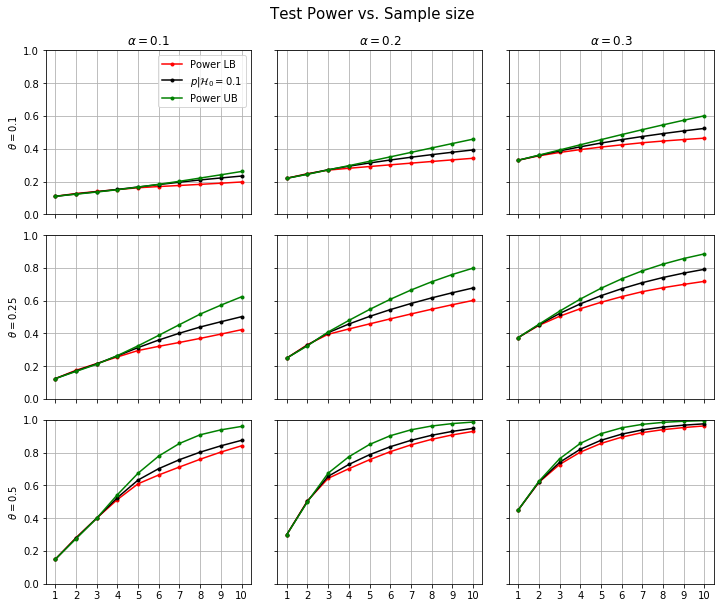

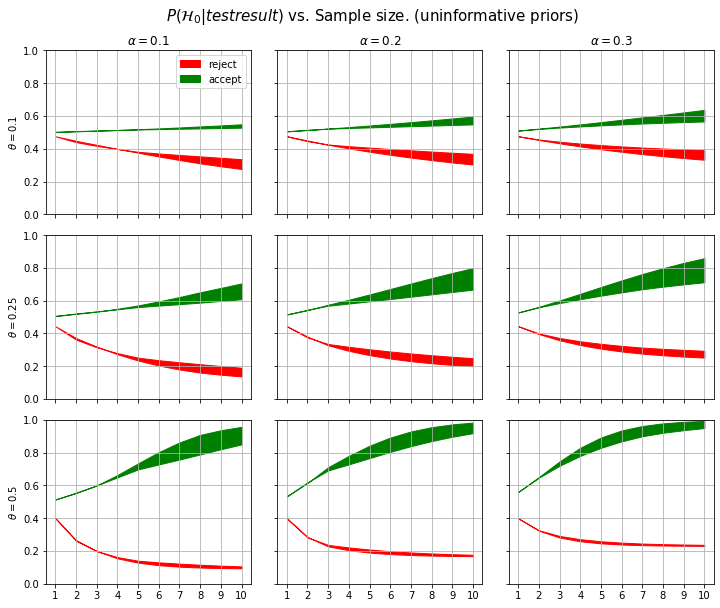

In [5]:

class Hypothesis:
    def __init__(self, pH0, theta):
        self.pH0 = pH0
        self.pH1 = pH0 + theta
        
def fisher_test_manual(x0, n0, x1, n1, alpha):
    cont_table = [[x0, x1], [n0-x0, n1-x1]]
    hg = stats.hypergeom(M=n0+n1, n=x0+x1, N=n1)
    pgeq = sum(hg.pmf(k) for k in range(x1, n1+1))    
    tmp = (alpha - (pgeq - hg.pmf(x1))) / hg.pmf(x1)
    rej = min(max(0, tmp), 1)
    return rej

def run(alpha, theta, n_max=10):
    test_LB = Hypothesis(pH0=0.5-theta/2, theta=theta)
    test_cust = Hypothesis(pH0=0.1, theta=theta)
    test_UB = Hypothesis(pH0=1-theta, theta=theta)

    tests = [test_LB, test_cust, test_UB]

    nn = np.arange(n_max) + 1
    rfish = np.zeros((3, n_max))
    for ni in range(len(nn)):
        n = nn[ni]
        for itest in range(len(tests)):
            for k0 in range(n+1):
                for k1 in range(n+1):
                    expect_rej = fisher_test_manual(k0, n, k1, n, alpha)
                    pr_state = stats.binom.pmf(k0, n, tests[itest].pH0) * stats.binom.pmf(k1, n, tests[itest].pH1)
                    rfish[itest, ni] += expect_rej * pr_state
    return rfish


alpha = [0.1, 0.2, 0.3]
theta = [0.1, 0.25, 0.5]

PrH0Rej = lambda a, pwr : (1 + pwr/a)**(-1) # Priors P(H0)=P(H1)=0.5
PrH0Acc = lambda a, pwr : (1 + (1-pwr)/(1-a))**(-1) # Priors P(H0)=P(H1)=0.5

fig, axs = plt.subplots(3,3, figsize=(10,8), sharex=True, sharey=True)
fig.suptitle('Test Power vs. Sample size', fontsize=15, y=1.05)
fig.tight_layout()

fig2, axs2 = plt.subplots(3,3, figsize=(10,8), sharex=True, sharey=True)
fig2.suptitle('$P(\mathcal{H}_0|test result)$ vs. Sample size. (uninformative priors)', fontsize=15, y=1.05)
fig2.tight_layout()

n_max = 10
nn = np.arange(n_max) + 1
for col in range(len(alpha)):
    for row in range(len(theta)):
        np.random.seed(0)
        res = run(alpha=alpha[col], theta=theta[row], n_max=n_max)
        axs[row,col].plot(nn, res[0], marker='.', color='r', label='Power LB') # custom
        axs[row,col].plot(nn, res[1], marker='.', color='k', label='$p|\mathcal{H}_0=0.1$') # 
        axs[row,col].plot(nn, res[2], marker='.', color='g', label='Power UB') # around 0.5
        axs[row,col].set_ylim([0, 1.0])
        axs[row,col].set_xticks(np.arange(n_max)+1)
        axs[row,col].grid()
        
        
        axs2[row,col].fill_between(nn, PrH0Rej(alpha[col], res[0]), PrH0Rej(alpha[col], res[2]), color='r', alpha=1.0, label='reject')
        axs2[row,col].fill_between(nn, PrH0Acc(alpha[col], res[0]), PrH0Acc(alpha[col], res[2]), color='g', alpha=1.0, label='accept')
        axs2[row,col].set_ylim([0, 1.0])
        axs2[row,col].set_xticks(np.arange(n_max)+1)
        axs2[row,col].grid()        


        
for i in range(axs.shape[0]):
    axs[i,0].set_ylabel('$\\theta={}$'.format(theta[i]))
    axs2[i,0].set_ylabel('$\\theta={}$'.format(theta[i]))
for i in range(axs.shape[1]):
    axs[0,i].set_title('$\\alpha={}$'.format(alpha[i]))
    axs2[0,i].set_title('$\\alpha={}$'.format(alpha[i]))
    
axs[0,0].legend()
axs2[0,0].legend()
plt.show()

E.g. if allow a false positive rate of 20% ($\alpha=0.2$), and want a true positive rate of minimum 60% to detect a change of 25% points or more, we require 6 samples in the best case (power UB) and 10 samples in the worst case (power LB).

Alternatively, if we specify the priors $P(\mathcal{H}_0) = P(\mathcal{H}_1) = 0.5$, we can map the power to the probability of the null hypothesis being true, given the test result. Hence, with 6 samples, if the test cannot reject $\mathcal{H}_0$, the probability is 60%-67% that the null hyopthesis is true, whereas if the test rejects $\mathcal{H}_0$, the probability is 25%-30% that $\mathcal{H}_0$ is true. 

### 1.2.2. Bayesianism


TODO: Hypothesis testing with beta priors

TODO: expected loss (expected change in p) instead of binary testing


# 2. Point estimation of N ordered binomials.

Given $N$ ordered coins, and for each coin $i=1,...,N$ some trials $X_i \sim Bin(n_i, p_i)$. The coins are ordered in the sense that it is known a priori that the success rates are monotonically increasing, i.e. given the event $\mathcal{M}:p_1 \leq p_2 \leq ... \leq p_N$.

### 2.1. Conditional MLE

If $f$ is the binomial pmf, then the pmf conditional on $\pmb{p}\in \mathcal{M}$  is given by

$f_{\pmb{X}|\pmb{X} \in \mathcal{M}}(\pmb{k}, \pmb{p}) = \frac{f_{\pmb{X}}(\pmb{k}, \pmb{p}) \cdot \pmb{1}(\pmb{X} \in \mathcal{M})}{P(\pmb{X} \in \mathcal{M})}  \propto  f_{\pmb{X}}(\pmb{k}, \pmb{p}) \cdot \pmb{1}(\pmb{X} \in \mathcal{M})$

Hence, we can find the MLE estimate for the conditional density as
$\pmb{\hat{p}} = argmax_{\pmb{p}} \hat{L}(\pmb{p}|\pmb{n},\pmb{x})$ s.t. $\pmb{p} \in \mathcal{M}$

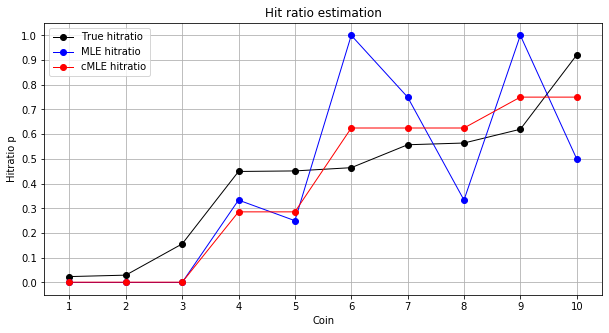

In [6]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
import coinest as coins
%matplotlib inline

import warnings
from scipy.optimize import minimize, LinearConstraint
import scipy.stats as stats
def cmle_loglike(p, nvec, kvec):
    loglike = 0
    for i in range(p.shape[0]):
        loglike += -np.log(stats.binom.pmf(kvec[i], nvec[i], p[i]))
    return loglike

def cmle_est(ntrials, nsucc):
    ''' Conditional MLE argmax f(p|n,x) s.t. p monotonically incr parameters. '''
    ncoins = ntrials.shape[0]
    constraints = {'type':'ineq', 'fun':lambda x : np.diff(x)} # np.diff(x) > 0 constraint
    bounds = [(0.001, 0.999)] * ncoins
    x0 = [i/(ncoins+1) for i in range(ncoins)]
    res = minimize(cmle_loglike, x0, args=(ntrials, nsucc), bounds=bounds, constraints=constraints)
    if not res.success:
        warnings.warn(res.message, RuntimeWarning)
    return res.x

def mle_est(ntrials, ksucc):
    ''' MLE argmax f(p|n,x) '''
    return ksucc / ntrials

def sample_true_p(ncoins, dist):
    return np.sort(dist.rvs(ncoins))

def get_sample_data(ncoins):
    # Use beta as conjugate prior. Uniform: alpha=beta=1. Highly biased symmetric alpha=beta close to 0.
    alpha = beta = 1.0
    dist = stats.beta(alpha, beta)

    p_true = coins.sample_true_p(ncoins, dist)
    assert (np.diff(p_true)>=0).all(), "p_true is not monotonically increasing"

    # Simulate some #trials.
    ntrials = np.random.randint(1, 5, size=ncoins)

    # Simulate successes.
    X = np.random.binomial(ntrials, p_true, size=ncoins)
    
    return p_true, ntrials, X


if 1:
    # === Generate some sample data ===
    p_true, ntrials, X = get_sample_data(ncoins = 10)
else:
    ntrials = np.array([5, 6, 4])
    X = np.array([1, 4, 2])
    try: del p_true
    except: pass

# Estimation
p_hat_mle = coins.mle_est(ntrials, X)
p_hat_cmle = coins.cmle_est(ntrials, X)

# Plot
plt.figure(figsize=(10,5))
plt.title('Hit ratio estimation'); plt.xlabel('Coin'); plt.ylabel('Hitratio p')
xx = np.arange(ntrials.shape[0]) + 1
if 'p_true' in locals():
    plt.plot(xx, p_true, color='k', marker='o', linewidth=1.0, label='True hitratio')
plt.plot(xx, p_hat_mle, color='b', marker='o', linewidth=1.0, label='MLE hitratio')
plt.plot(xx, p_hat_cmle, color='r', marker='o', linewidth=1.0, label='cMLE hitratio')
plt.xticks(xx); plt.yticks(np.arange(11)/10)
plt.grid(); plt.legend()
plt.show()

The black line represent the true success rates (hit ratios) for each coin. The blue line is the result of naive MLE, which does not take into account the a priori information that success rates are monotonically increasing. The red line represent a conditional MLE, i.e. an MLE performed over the monotonic parameter space.

# 3. Bidding in blind auction against competition
Consider bidding in an auction against a competitor, where the highest bidder wins the auction and pays the bid price. The auction is blind, in the sense that bidders are blind to other participants bids.

## 3.1. Competitor bids $\sim F_B$
let $B$ be the comeptitor's bid which follow some stationary distribution $F_B$ parameterized by $\theta$, and let our bid price be denoted by $x$. We win the auction when we bid higher than our competitor. Hence, our stochastic win rate (Hit Ratio) is $W = 1\{x-B\} = H(x-B)$, where $H(\cdot)$ is the Heaviside step function.

\begin{align}
W &= H(x-B) \sim Bern(F_B(x)) \\
\mathbb{E}[W] &= F_B(x) \\
\mathbb{V}[W] &= F_B(x)(1-F_B(x))
\end{align}

If we win the bid, we can sell the asset at a price $x<m$, with a conditional profit of $Pnl=m-x$. Hence, $c$ is our break-even price, or the maximum price we are willing to bid.

\begin{align}
Pnl &= W \cdot(m-x) \\
\mathbb{E}[Pnl] &= F_B(x)(m-x) \\
\mathbb{V}[Pnl] &= F_B(x)(1-F_B(x))(m-x)^2
\end{align}

The only uncertainty in the Pnl comes from the win rate $W$.

Assume that we have participated in $n$ auctions, each auction with bid price and win result given by $\{x_i, w_i\}$, for $i=1,...,n$.

Maximum likelihood estimation yields $\hat{\theta}_n = \underset{\theta}{argmax} \prod\limits_{i=1}^n F_B(x_i)^{w_i} (1-F_B(x_i))^{1-w_i}$.

Now using this estimation, we want to find our next bid such that we maximize expected pnl, or more generally, expectation of some utility function $U(x)$ of pnl.

\begin{align}
    x_{n+1} := \underset{x}{argmax} \; \mathbb{E}[U(Pnl)|\theta=\hat{\theta}_n]
\end{align}

For instance, chosing the exponential utility function $U(x) = (1-e^{-qx})/q$ we get

\begin{align}
    x_{n+1} := \underset{x}{argmax} \; \frac{1-e^{-q(m-x)}}{q}F_B(x; \hat{\theta}_n)
\end{align}

[]

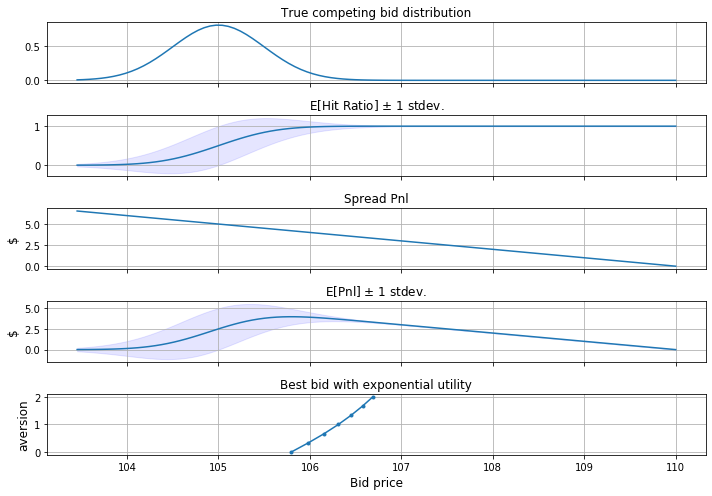

In [7]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from scipy.optimize import minimize

m = 110 # Break even point.
loc = 105
scale = 0.5
B = stats.norm(loc=loc,scale=scale)
#B = stats.uniform(loc=mu-sigma*3**0.5, scale=2*sigma*3**0.5)
xx = np.linspace(B.ppf(0.001), m, 100)

fig, axs = plt.subplots(5, 1, figsize=(10,7), sharex=True)
axs[0].set_title('True competing bid distribution')
axs[0].plot(xx, B.pdf(xx))

axs[1].set_title('E[Hit Ratio] $\pm$ 1 stdev.')
EW = B.cdf(xx)
VW = B.cdf(xx) * (1 - B.cdf(xx))
axs[1].plot(xx, EW)
axs[1].fill_between(xx, EW - np.sqrt(VW), EW + np.sqrt(VW), color='blue', alpha='0.1')

axs[2].set_title('Spread Pnl')
axs[2].set_ylabel('$', fontsize=12)
axs[2].plot(xx, (m-xx))

axs[3].set_title('E[Pnl] $\pm$ 1 stdev.')
axs[3].set_ylabel('$', fontsize=12)
EPNL = B.cdf(xx)*(m-xx)
axs[3].plot(xx, EPNL)
VPNL = B.cdf(xx) * (m-xx)**2 * (1-B.cdf(xx))
axs[3].fill_between(xx, EPNL - np.sqrt(VPNL), EPNL + np.sqrt(VPNL), color='blue', alpha='0.1')

def eutil(x, q):
    if q == 0.0:
        eutil = (m-x)*B.cdf(x)
    else:
        eutil = 1/q*(1-np.exp(-q*(m-x)))*B.cdf(x)
    return -eutil

qq = np.linspace(0, 2, 6+1)
xoptim = np.zeros_like(qq, float)
x0 = B.stats(moments='m')
for i in range(qq.shape[0]):
    res = minimize(eutil, x0=x0, args=(qq[i]))
    xoptim[i] = res.x
    x0 = res.x

axs[4].set_title('Best bid with exponential utility')
axs[4].set_ylabel('aversion', fontsize=12)
axs[4].set_xlabel('Bid price', fontsize=12)
axs[4].plot(xoptim, qq, marker='.')

for ax in axs:
    ax.grid()
fig.tight_layout()
plt.plot()

## 3.1.1. A simple example
Let the comeptitor's bid follow a staionary Gaussian distribution $B \sim \mathcal{N}(\mu, \sigma^2)$ with unknown mean and known variance. Then $F_B(x) = F\left(\frac{x-\mu}{\sigma}\right)$, where $F$ is the standard normal cdf.

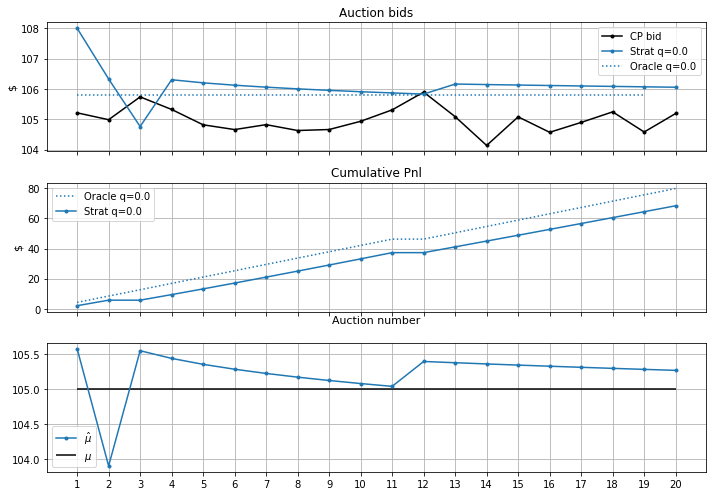

In [8]:
from scipy.optimize import minimize

def logL(x, dist, xprice, xhit):
    cdf = dist(x).cdf(xprice)
    cdf[cdf==1] = 0.9999
    cdf[cdf==0] = 0.0001
    logL = xhit * np.log(cdf) + (1-xhit)*np.log(1-cdf)
    return -logL.sum()

def eutil(x, theta, dist, q):
    if q == 0.0:
        eutil = (m-x)*dist(theta).cdf(x)
    else:
        eutil = 1/q*(1-np.exp(-q*(m-x)))*dist(theta).cdf(x)
    return -eutil

class Strat:
    def __init__(self, name, bidinit, breakeven, riskaversion, dist):
        self.name = name
        self.riskaversion = riskaversion
        self.breakeven = breakeven
        self.pnl = []
        self.wins = []
        self.bidprice = []
        self.nextbid = bidinit
        self.theta = []
        self.dist = dist
    
    def step1_auction(self, cpbid): # cheating here, CP's price not public (shouldnt be exposed here)...
        ourbid = self.nextbid
        won = (cpbid < ourbid)
        spread = (self.breakeven - ourbid)
        profit = 1*won*spread
        self.bidprice += [ourbid]
        self.wins += [1*won]
        self.pnl += [profit]
        
    def step2_est_dist(self, sigma):
        args = (self.dist, np.array(self.bidprice), np.array(self.wins))
        theta_guess = self.bidprice[-1]
        res = minimize(logL, x0=theta_guess, args=args)
        self.theta += [res.x[0]]
        
    def step3_est_bid(self):
        args = (self.theta[-1], self.dist, self.riskaversion)
        res_price = minimize(eutil, x0=self.theta[-1], args=args)
        self.nextbid = res_price.x[0]

        
T = 20
#m = 110
mu = loc #105.0
sigma = scale #1.0
B = stats.norm(loc=mu,scale=sigma) # True competitor's bidding dist.
#B = stats.uniform(loc=mu-sigma*3**0.5, scale=2*sigma*3**0.5)

firstbid = 108
#dd = lambda theta : stats.norm(loc=theta, scale=sigma)
strats = [
        Strat(name='q=0',
              bidinit=firstbid,
              breakeven=m,
              riskaversion=0.0,
              dist=lambda theta : stats.norm(loc=theta, scale=sigma)) # Assumption on dist used for estimation.
    ]

cp_bids = B.rvs(T)
for it in range(T):
    cpbid = cp_bids[it]
    for strat in strats:
        strat.step1_auction(cpbid)
        strat.step2_est_dist(sigma)
        strat.step3_est_bid()

        
# ===== Plot rival bids =====
TT = np.arange(T)+1
cpmu, cpvar = B.stats(moments='mv')
fig, axs = plt.subplots(3,1, sharex=True, figsize=(10, 7))
axs[0].set_title('Auction bids')
axs[0].set_ylabel('$', fontsize=11)
axs[1].set_title('Cumulative Pnl')
axs[1].set_ylabel('$', fontsize=11)
axs[1].set_xlabel('Auction number', fontsize=11)

axs[0].plot(TT, cp_bids, color='k', marker='.', label='CP bid')

# ===== Plot strategies =====
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, strat in enumerate(strats):
    
    # Find oracle bid and pnl. I.e. if we knew the rival's bid distribution.
    args = (cpmu, lambda theta: B, strat.riskaversion)
    oracle_bid = minimize(eutil, x0=cpmu, args=args).x
    oracle_pnl = (cp_bids < oracle_bid)*(strat.breakeven-oracle_bid)
    
    oracle_label = 'Oracle q={}'.format(strat.riskaversion)
    axs[0].hlines(oracle_bid, 1, T-1, linestyle='dotted', label=oracle_label, color=colors[i])
    axs[1].plot(TT, np.cumsum(oracle_pnl), linestyle='dotted', label=oracle_label, color=colors[i])
    
    # Strategy bids and resulting pnl.
    strat_label = 'Strat q={}'.format(strat.riskaversion)
    axs[0].plot(TT, np.array(strat.bidprice), marker='.', label=strat_label, color=colors[i])
    axs[1].plot(TT, np.cumsum(np.array(strat.pnl)), marker='.', label=strat_label, color=colors[i])
    axs[1].set_xticks(TT)
    
    axs[2].plot(TT, strat.theta, marker='.', label='$\hat{\mu}$')
    axs[2].hlines(mu, 1, TT[-1], label='$\mu$')

for ax in axs.flatten():
    ax.grid()
    ax.legend()
fig.tight_layout()
#print('Pnl/step {}'.format(xpnl.mean()))

The assumption of Gaussian kernel and variance in the maximization, is not critical. The procesdure is quite robust to a misspecification of the distribution and/or known variance. The infinite support for the Gaussian kernel ensures that the expected Pnl is a smooth function, and easy to maximize.

## 3.2 When individual valuation follows $\sim F_V$



Now instead of assuming a competitor bidding distribution, we assume that there are $n$ competitors, where ours and their valuations of the auctioned asset is each drawn indepdently from a distribution $F_V$. Fluctuations in valuation can be seen as different interest in the asset at that particular time. A player can only observe their own valuation.

The natural question is, what should we bid, given our own valuation, in order to maximize our profits? Our strategy naturally depends on the strategy of our competitors. If we assume that all participants are risk-neutral, or equivalently, participant each tries to maximize their own profit, then due to the symmetry, all participating players will adopt the same strategy. Note that no cooperation is allowed, for else, the optimal coperative strategy would be to bid zero, with breaking ties at random/evenly. Instead, our goal is to find the Baysian Nash equilibrium strategy $g(v)$.

Since a player will never bid more than their valuation, we have that $g_i(v_i) < v_i$. We further demand that $g_i$ is a strictly monotonic function, that is, the player will increase its bid with increasing valuation. This ensures that the function is invertible, and implies that the plauer with the highest valuation will bid the highest and win the auction.

The distribution of the highest valuation $V_{(n)}$ among our competitors is

$F_{V_{(n)}}(v) = F_V(v)^n$

the distribution of the highest bid $B_{(n)}$ <u>among our competitors</u> is then

$F_{B_{(n)}}(b) = P(\max g(V_i) \leq b) = P(g(V_{(n)})\leq b) = F_{V_{(n)}}(g^{-1}(b)) = F_{V}(g^{-1}(b))^n$

If we observe valuation $v$ and decide to bid $x$ our profit is given by

$Pnl = H(x - B_{(n)})(v-x)$

$E[Pnl] = (v-x)F_{B_{(n)}}(x) = (v-x)F_{V_{(n)}}(g^{-1}(x))$

With first order condition 

$\frac{dE[Pnl]}{dx} = -F_{V_{(n)}}(g^{-1}(x)) + (v-x)f_{V_{(n)}}(g^{-1}(x))\cdot \frac{1}{g'(g^{-1}(x))} = 0$

Now at symmetric equilibrium, our strategy will equal our competitors, so that $x=g(v)$. Inserting into the equation yields the ODE

$g'(v)F_{V_{(n)}}(v) + g(v)f_{V_{(n)}}(v) = vf_{V_{(n)}}(v)$

with solution

$g(v) = \frac{1}{F_{V_{(n)}}(v)} \int_{-\infty}^v s f_{V_{(n)}}(s)ds = E[V_{(n)}|V_{(n)} \leq v]$.

The density of the winning bid in the auction (n+1 participants) is then

$f_{B_{(n+1)}}(g(v)) = \frac{n+1}{n}\frac{F_V(v)^{n+1}}{v-g(v)}$

In the special case when $n=1$ (one competitor), and $F_{V_{(n)}}(v) = F_{V}(v) \sim \mathcal{N}(\mu, \sigma^2)$

$g(v) = \mu - \sigma \frac{f(\frac{v-\mu}{\sigma})}{F(\frac{v-\mu}{\sigma})}$.

Notice that negative valuation and negative bids are allowed. If this is a problem, one may chose either the truncated or rectified Normal distribution.

Mean participant Pnl = 0.56
Mean auction execution price = 9.15


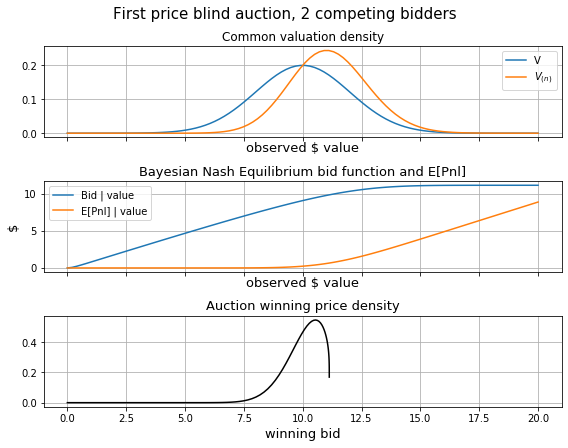

In [15]:
from scipy.integrate import quad
np.seterr(all='raise')
loc = 10
scale = 2
V = stats.norm(loc=loc, scale=scale)
n = 2 # Number of competing participants

def bid(value, n=1):
    if n == 1:
        bid = loc - scale**2*V.pdf(value) / V.cdf(value)
    else:
        Vloc, Vscale = V.stats(moments='mv'); Vscale = Vscale**0.5
        integral = quad(lambda v : V.cdf(v)**n, Vloc-Vscale*5, value)
        bid = value - 1/V.cdf(value)**n * integral[0]
    epnl = (value - bid)*V.cdf(value)**n
    return bid, epnl
    
# ====================
# ===== Plotting =====
# ====================
fig, axs = plt.subplots(3, 1, figsize=(8,6), sharex=True)
fig.suptitle('First price blind auction, {} competing bidders'.format(n), y=1.03, fontsize=15)
vals = np.linspace(1e-5, loc*2, 100)
bids, epnl = zip(*[bid(v, n) for v in vals])
bids = np.array(bids)
epnl = np.array(epnl)

axs[0].set_title('Common valuation density')
axs[0].set_xlabel('observed $ value', fontsize=13)
axs[0].plot(vals, V.pdf(vals), label='V')
axs[0].plot(vals, n*V.cdf(vals)**(n-1)*V.pdf(vals), label='$V_{(n)}$')
axs[0].legend()

axs[1].set_title('Bayesian Nash Equilibrium bid function and E[Pnl]', fontsize=13)
axs[1].set_xlabel('observed $ value', fontsize=13)
axs[1].set_ylabel('$', fontsize=13)
axs[1].plot(vals, bids, label='Bid | value')
#axs[1].plot(vals, vals, color='k', label='')
axs[1].plot(vals, epnl, label='E[Pnl] | value')
axs[1].legend()

axs[2].set_title('Auction winning price density', fontsize=13)
m = n+1 # m=n+1 for distribution of winning bid. m=n for competitors highest bid.
axs[2].plot(bids, m*V.cdf(vals)**m / (n*(vals-bids)), color='k')
axs[2].set_xlabel('winning bid', fontsize=13)

#axs[3].set_title('Our Pnl distribution', fontsize=13)
#axs[3].set_xlabel('observed $ value', fontsize=13)
#axs[3].set_ylabel('$', fontsize=13)
# axs[3].plot(bids, V.cdf(vals) / (n*(vals-bids))) density of bids for each player. f_v mapped to g(v)

EPNL = quad(lambda value: bid(value,n)[1]*V.pdf(value), 0, loc*2)[0]
print('Mean participant Pnl = {:.2f}'.format(EPNL))
EB = quad(lambda value: (n+1)*bid(value)[0]* V.pdf(value) * V.cdf(value)**n, 0, loc*2)[0]
print('Mean auction execution price = {:.2f}'.format(EB))

for ax in axs.flatten():
    ax.grid()
fig.tight_layout()

# === Simulation ====
if 0:
    nsim = 10000
    obs = V.rvs((nsim, n+1))
    pnl = np.zeros(nsim)
    winprice = np.empty(nsim)
    for i in range(nsim):
        v1 = obs[i,0]
        v2 = obs[i,1]
        b1,_ = bid(v1, n)
        b2,_ = bid(v2, n)
        pnl[i] = (b2>b1)*(v2-b2)
        winprice[i] = max(b1,b2)
    plt.figure()
    axs[1].hist(winprice, bins=100, density=True)
    plt.figure()
    plt.hist(pnl[pnl>0], bins=100, density=True)
    print(pnl.mean())
    print(pnl[pnl>0].mean())
    plt.show()

# Market Making

That is, we are a monopolistic dealer in a single security, and publish bid/ask spreads in the market. At each time step, orders arrives with some probably that decays with the size of the bid/ask. The task is to find what bid/ask spreads to publish, and what proportion of inventory to hedge in the market (which we have to pay for).

Hence, the terminal cumulative Pnl is a stochastic metric which is a function of the time dependent parameters (bid, ask, hedge ratio).

    Algo 1: Finds spreads and amount to hedge by maximizing the expected Pnl.
    Algo 2: Finds spreads and amount to hedge by maximizing the Pnl Sharpe ratio.
    Algo 3: Finds spreads and amount to hedge by maximizing the expected exponential utility function of the Pnl.

All algos are greedy in the sense that they only consider step-wise maximization over every time step, and not over the full time space.

Result:
* Algo 1 has the highest expected terminal profit, since it disregards inventory risk, but also highest volatility among the algos. Since the order arrival distribution is time stationary, bids and asks are time invariant. That is, neither internalization nor hedging are performed due to the ignorance of risk.
* Algo 2 penalizes inventory risk, but not enough to make a large impact on volatility. This is likely due to the greedy step wise approach. Some internalization through narrowing of bid ask, but almost no skewing.
* Algo 3 penalizes inventory risk according to our risk aversion (reduces to Algo 1 as a special case when risk-neutral). Spreads turns out to be published at a risk neutral baseline (+-1 USD), with skewing on top to avoid inventory to drift too far away from flat. When internalization fails and inventory drifts too far, costly hedging is performed. The more risk-averse we are, the more aggressive we are on our spreads, and the more we are going to hedge in the market. The time of hedging can be equivalently expressed as inventory hitting a risk-limit.


[]

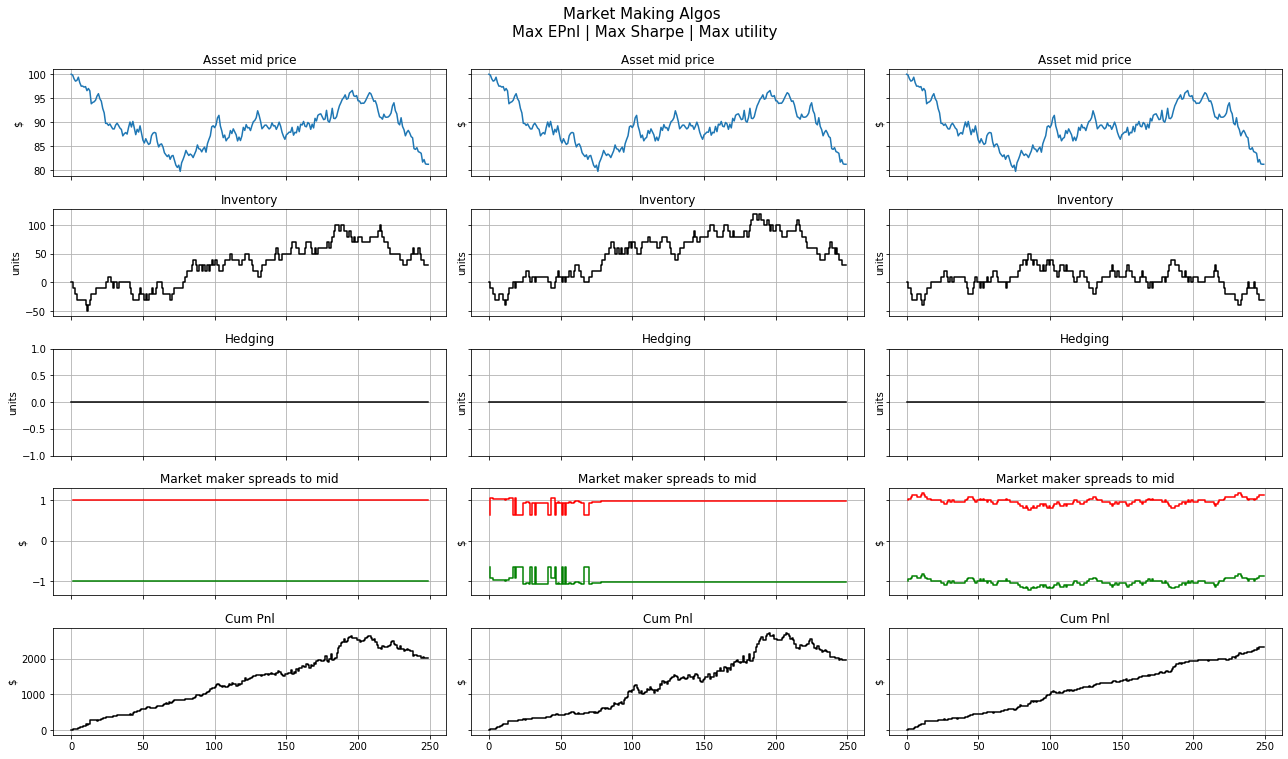

In [10]:
alpha = 1.0
T = 250
TT = np.arange(T)
s0 = 100
blackvol = 0.15 / (250)**0.5
vol = s0*(np.exp(blackvol**2)-1)**0.5
hdgCost = 0.5
# ========
from scipy.optimize import minimize

def Amu(a):
    return np.exp(-alpha*a)
def Bmu(b):
    return Amu(b)

def E(bidsprd, asksprd, hdgprop, state):
    I = state['inventory']
    s = state['mtmprice']
    return asksprd*Amu(asksprd) + bidsprd*Bmu(bidsprd) - hdgprop*np.abs(I)*hdgCost

def V(bidsprd, asksprd, hdgprop, state):
    muA = Amu(asksprd)
    muB = Bmu(bidsprd)
    I = state['inventory']
    volterm1 = (1-hdgprop)*I*((1-hdgprop)*I - hdgprop + 2*(muB-muA))
    volterm2 = muB - 2*muA*muB + muA
    term3 = asksprd**2 * muA*(1-muA) + bidsprd**2 * muB*(1-muB)
    return (volterm1 + volterm2)*vol**2 + term3

def sharpe_cost(x, state):
    bidsprd = x[0]
    asksprd = x[1]
    hdgprop = x[2] if state['allowHdg'] else 0.0
    return -E(bidsprd, asksprd, hdgprop, state)/V(bidsprd, asksprd, hdgprop, state)**0.5

def exputil_cost_legacy(x, state):
    b, a = (x[0], x[1])
    hdgprop = x[2] if state['allowHdg'] else 0.0
    #print('hdgprop: {}'.format(hdgprop))
    s = state['mtmprice']
    I = state['inventory']
    Ipost = I #*(1.0-hdgprop)
    q = state['exputil_q']
    muA = np.exp(-alpha*a)
    muB = np.exp(-alpha*b)
    psi = (q*vol)**2
    e1 = np.exp(psi*Ipost**2)*(1-muA)*(1-muB)
    e2 = np.exp(-q*b + psi*(Ipost+1)**2)*(1-muA)*muB
    e3 = np.exp(-q*a + psi*(Ipost-1)**2)*muA*(1-muB)
    e4 = np.exp(-q*(a+b) + psi*Ipost**2)*muA*muB
    #print((psi*Ipost**2, -q*b + psi*(Ipost+1)**2, -q*a + psi*(Ipost-1)**2, -q*(a+b) + psi*Ipost**2))
    hdgfactor = 1.0 #np.exp(-q*hdgprop*I*(1-hdgCost-s))
    #print('hdgfactor: {}'.format(hdgprop))
    tmp = -1/q*(1-(e1 + e2 + e3 + e4)) * hdgfactor
    if np.isinf(tmp):
        print('===== INF DETECTED =====')
        print(Ipost**2)
        print(psi*Ipost**2)
        print(-q*b + psi*(Ipost+1)**2)
        print(-q*a + psi*(Ipost-1)**2)
        print(-q*(a+b) + psi*Ipost**2)
    return -1/q*(1-(e1 + e2 + e3 + e4)) * hdgfactor

def exputil_cost(x, state):
    b, a = (x[0], x[1])
    hdgprop = x[2] if state['allowHdg'] else 0.0
    #print('hdgprop: {}'.format(hdgprop))
    s = state['mtmprice']
    I = state['inventory']
    Ipost = I #*(1.0-hdgprop)
    q = state['exputil_q']
    muA = np.exp(-alpha*a)
    muB = np.exp(-alpha*b)
    Q1 = lambda Ai,Bi: Bi-Ai + (1-hdgprop)*I
    Q2 = lambda Ai,Bi: a*Ai + b*Bi - hdgprop*np.abs(I)*hdgCost
    PrAB = lambda Ai,Bi: muA**Ai * (1-muA)**(1-Ai) * muB**Bi * (1-muB)**(1-Bi)
    caseAB = lambda Ai, Bi: np.exp(0.5*(q*vol)**2 * Q1(Ai,Bi)**2 - q*Q2(Ai,Bi))
    case00 = caseAB(0,0)*PrAB(0,0)
    case01 = caseAB(0,1)*PrAB(0,1)
    case10 = caseAB(1,0)*PrAB(1,0)
    case11 = caseAB(1,1)*PrAB(1,1)
    return -1/q * (1.0 - (case00 + case01 + case10 + case11))

def algo_max_epnl(state):
    a = max(0, 1/alpha)
    b = max(0, 1/alpha)
    return np.array([b, a, 0.0])
    
def algo_max_sharpe(state):
    bnds = [(1e-10, None), (1e-10, None), (1e-10, 0.99999)]
    x0 = (state['prev_bidsprd'], state['prev_asksprd'], 0.0)
    res = minimize(sharpe_cost, x0, args=(state), bounds=bnds)
    return res.x

def algo_max_exputil(state, riskaversion):
    bnds = [(1e-10, 5.0), (1e-10, 5.0), (1e-10, 0.99999)]
    x0 = (state['prev_bidsprd'], state['prev_asksprd'], 1e-9)
    state['exputil_q'] = riskaversion
    res = minimize(exputil_cost, x0, args=(state), bounds=bnds)
    return res.x

# ========
class Trade:
    def __init__(self, itime, size, direction, midprice, sprd):
        self.itime = itime
        self.sprd = sprd
        self.direction = direction
        self.midprice = midprice
        self.size = size
        
class Market:
    def __init__(self, s0, vol, rnd_state=None):
        self.itime = 0
        self.s = [s0]
        self.vol = vol
        self.rnd_state = rnd_state
    def evolve(self):
        s = self.s[-1] + self.vol*stats.norm().rvs(self.rnd_state)
        self.s += [s]
        self.itime +=1
        return
    def match(self, bidsprd, asksprd):
        if hasattr(self, '_urnd') and self._urnd[0] == self.itime:
            urnd = self._urnd[1]
        else:
            urnd = stats.uniform().rvs(2)
            setattr(self, '_urnd', (self.itime, urnd))
        
        pHitAsk = np.exp(-alpha*asksprd)
        pHitBid = np.exp(-alpha*bidsprd)
        trds = []
        if urnd[0] < np.exp(-alpha*asksprd):
            trds.append(Trade(itime=self.itime, size=10, direction=-1, midprice=self.s[self.itime], sprd=asksprd))
        if urnd[1] < np.exp(-alpha*bidsprd):
            trds.append(Trade(itime=self.itime, size=10, direction=+1, midprice=self.s[self.itime], sprd=bidsprd))
        return trds
    
#    def hedge(self, size, direction):
#        trds = []
#        trds.append(Trade(itime=self.itime, size=size, direction=direction, midprice=self.s[self.itime], sprd=hdgCost))
#        return trds
    
class Agent:
    def __init__(self, name, algo_func):
        self.name = name
        self.inv = [0]
        self.cash = [0]
        self.mtm = [0]
        self.cpnl = [0]
        self.bidsprd = [0]
        self.asksprd = [0]
        self.hdgprop = [0]
        self.algo_func = algo_func
    def pnl(self):
        return np.insert(np.diff(self.cpnl), 0, 0)
    def update(self, trades, mtmprice):
        deltaUnits = sum(trd.direction*trd.size for trd in trades)
        deltaCash = sum((trd.sprd - trd.direction*trd.midprice)*trd.size for trd in trades)
        self.inv.append(self.inv[-1] + deltaUnits)
        self.cash.append(self.cash[-1] + deltaCash)
        self.mtm.append(self.inv[-1] * mtmprice)
        self.cpnl.append(self.cash[-1] + self.mtm[-1])
        state = {
            'inventory':self.inv[-1],
            'mtmprice':mtmprice,
            'prev_bidsprd': self.bidsprd[-1],
            'prev_asksprd': self.asksprd[-1],
            'allowHdg': True
            }
        bidsprd, asksprd, hdgprop = self.algo_func(state)
        #print('publish: {}, {}'.format(bidsprd, asksprd))
        if np.isnan(bidsprd) or np.isnan(asksprd):
            print(state)
        
        # Hedge
        self.cash[-1] += hdgprop*(self.inv[-1]*mtmprice - np.abs(self.inv[-1])*hdgCost)
        self.inv[-1] *= (1-hdgprop)
        self.mtm[-1] = self.inv[-1]*mtmprice
        self.cpnl[-1] = (self.cash[-1] + self.mtm[-1])
        
        self.bidsprd.append(bidsprd)
        self.asksprd.append(asksprd)
        self.hdgprop.append(hdgprop)
        return (bidsprd, asksprd)
# ========


nsim = 100
pnlsim = np.zeros((nsim, 3))
pnlvolsim = np.zeros((nsim, 3))
for i in range(nsim):
    exchange = Market(s0=s0, vol=vol)
    agent1 = Agent(name='Max EPnl', algo_func=algo_max_epnl)
    agent2 = Agent(name='Max Sharpe', algo_func=algo_max_sharpe)
    agent3 = Agent(name='Max utility', algo_func=lambda state : algo_max_exputil(state, riskaversion=0.005))

    agents = [agent1, agent2, agent3]
    trds = [[]]*len(agents)
    for i in range(1, T):
        exchange.evolve()
        for i in range(len(agents)):
            bidask = agents[i].update(trds[i], mtmprice=exchange.s[-1])
            trds[i] = exchange.match(bidask[0], bidask[1])
    
    for ak, a in enumerate(agents):
        pnl = a.pnl()
        pnlsim[i, ak] = np.mean(pnl)
        pnlvolsim[i, ak] = np.std(pnl)

epnl = np.mean(pnlsim, axis=0)
epnlvol = np.mean(pnlvolsim, axis=0)
#print(epnl)
#print(epnlvol)

fig, axs = plt.subplots(5, 3, figsize=(18,10), sharex='col', sharey='row')
maintitle = 'Market Making Algos \n' + ' | '.join([a.name for a in agents])
fig.suptitle(maintitle, fontsize=15, y=1.05)
for i,agnt in enumerate(agents):
    axs[0,i].set_title('Asset mid price')
    axs[0,i].set_ylabel('$')
    axs[0,i].plot(exchange.s)
    
    axs[1,i].set_title('Inventory')
    axs[1,i].set_ylabel('units')
    axs[1,i].step(TT, agnt.inv, color='k')

    axs[2,i].set_title('Hedging')
    axs[2,i].set_ylabel('units')
    axs[2,i].step(TT, np.array(agnt.hdgprop)*np.array(agnt.inv), color='k')
    lb, ub = axs[2,i].get_ylim()
    axs[2,i].set_ylim(min(lb, -1), max(ub, 1))
    #axs[2,i].set_ylim(axs[1,i].get_ylim())
    
    axs[3,i].set_title('Market maker spreads to mid')
    axs[3,i].set_ylabel('$')
    axs[3,i].step(TT[1::], agnt.asksprd[1::], color='r')
    axs[3,i].step(TT[1::], -np.array(agnt.bidsprd[1::]), color='g')

    axs[4,i].set_title('Cum Pnl')
    axs[4,i].set_ylabel('$')
    axs[4,i].step(TT, agnt.cpnl, color='k')
    #axs21 = axs[4,i].twinx()
    #axs21.set_ylabel('Cash, Mtm')
    #axs21.step(TT, agnt.mtm, color='b', linewidth=0.5)
    #axs21.step(TT, agnt.cash, color='y', linewidth=0.5)

for ax in axs.flatten():
    ax.grid()
fig.tight_layout()
plt.plot()